### Importing Necessary Libraries


In [2]:
from langchain.chat_models import ChatOpenAI
from langchain.document_loaders import  PyPDFLoader
from langchain.vectorstores import  FAISS
from langchain.text_splitter import  RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings 
from langchain.prompts import PromptTemplate
from langchain.retrievers.multi_query import MultiQueryRetriever
from langchain.chains import LLMChain
from langchain.docstore.document import Document
from langchain.chains.summarize import load_summarize_chain
from time import monotonic
from langchain_groq import ChatGroq
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from dotenv import load_dotenv
from langchain.agents import initialize_agent, Tool
from langchain.chains.question_answering import load_qa_chain
from pprint import pprint
import textwrap
import os
import ast
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    answer_correctness,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_similarity
)

from helper_functions import num_tokens_from_string, replace_t_with_space, replace_double_lines_with_one_line, split_into_chapters,\
is_similarity_ratio_lower_than_th, analyse_metric_results, escape_quotes

load_dotenv()

True

### Setting Preferred Encoding for PyPDF on Google Colab


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding # For using PyPDF on google colab 

### Setting OPENAI and GROQ API keys

In [3]:
os.environ["OPENAI_API_KEY"] = os.getenv('OPENAI_API_KEY')
groq_api_key = os.getenv('GROQ_API_KEY')

### Defining Path to Harry Potter PDF


In [4]:
hp_pdf_path ="Harry_Potter_Book_1_The_Sorcerers_Stone.pdf"

### Splitting the PDF into Chapters and Preprocessing


In [5]:
chapters = split_into_chapters(hp_pdf_path) 
chapters = replace_t_with_space(chapters)
print(len(chapters))

17


### Defining Prompt Template for Summarization


In [6]:
summarization_prompt_template = """Write an extensive summary of about of the following:

{text}

SUMMARY:"""

summarization_prompt = PromptTemplate(template=summarization_prompt_template, input_variables=["text"])

### Defining Function to Create Chapter Summaries using LLMs


In [7]:
def create_chapter_summary(chapter):
    """
    Creates a summary of a chapter using a large language model (LLM).

    Args:
        chapter: A Document object representing the chapter to summarize.

    Returns:
        A Document object containing the summary of the chapter.
    """

    chapter_txt = chapter.page_content  # Extract chapter text
    model_name = "gpt-3.5-turbo-0125"  # Specify LLM model
    llm = ChatOpenAI(temperature=0, model_name=model_name)  # Create LLM instance
    gpt_35_turbo_max_tokens = 16000  # Maximum token limit for the LLM
    verbose = False  # Set to True for more detailed output

    # Calculate number of tokens in the chapter text
    num_tokens = num_tokens_from_string(chapter_txt, model_name)

    # Choose appropriate chain type based on token count
    if num_tokens < gpt_35_turbo_max_tokens:
        chain = load_summarize_chain(llm, chain_type="stuff", prompt=summarization_prompt, verbose=verbose)
    else:
        chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=summarization_prompt, combine_prompt=summarization_prompt, verbose=verbose)

    start_time = monotonic()  # Start timer
    doc_chapter = Document(page_content=chapter_txt)  # Create Document object for chapter
    summary = chain.invoke([doc_chapter])  # Generate summary using the chain
    print(f"Chain type: {chain.__class__.__name__}")  # Print chain type
    print(f"Run time: {monotonic() - start_time}")  # Print execution time

    # Clean up summary text
    summary = replace_double_lines_with_one_line(summary["output_text"])

    # Create Document object for summary
    doc_summary = Document(page_content=summary, metadata=chapter.metadata)

    return doc_summary

### Generating Summaries for Each Chapter


In [ ]:
chapter_summaries = []
for chapter in chapters:
    chapter_summaries.append(create_chapter_summary(chapter))

### Function to Encode a Book into a Vector Store using OpenAI Embeddings


In [9]:
def encode_book(path, chunk_size=1000, chunk_overlap=200):
    """
    Encodes a PDF book into a vector store using OpenAI embeddings.

    Args:
        path: The path to the PDF file.
        chunk_size: The desired size of each text chunk.
        chunk_overlap: The amount of overlap between consecutive chunks.

    Returns:
        A FAISS vector store containing the encoded book content.
    """

    # Load PDF documents
    loader = PyPDFLoader(path)
    documents = loader.load()

    # Split documents into chunks
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, chunk_overlap=chunk_overlap, length_function=len
    )
    texts = text_splitter.split_documents(documents)
    cleaned_texts = replace_t_with_space(texts)

    # Create embeddings and vector store
    embeddings = OpenAIEmbeddings()
    vectorstore = FAISS.from_documents(cleaned_texts, embeddings)

    return vectorstore

### Encoding Chapter Summaries into Vector Store


In [10]:
def encode_chapter_summaries(chapter_summaries):
    """
    Encodes a list of chapter summaries into a vector store using OpenAI embeddings.

    Args:
        chapter_summaries: A list of Document objects representing the chapter summaries.

    Returns:
        A FAISS vector store containing the encoded chapter summaries.
    """

    embeddings = OpenAIEmbeddings()  # Create OpenAI embeddings
    chapter_summaries_vectorstore = FAISS.from_documents(chapter_summaries, embeddings)  # Create vector store
    return chapter_summaries_vectorstore

### Creating Vector Stores and Retrievers for Book and Chapter Summaries


In [4]:
# ### IF VECTOR STORES ALREADY EXIST, LOAD THEM
if os.path.exists("chunks_vector_store") and os.path.exists("chapter_summaries_vector_store"):
    embeddings = OpenAIEmbeddings()
    chunks_vector_store =  FAISS.load_local("chunks_vector_store", embeddings, allow_dangerous_deserialization=True)
    chapter_summaries_vector_store =  FAISS.load_local("chapter_summaries_vector_store", embeddings, allow_dangerous_deserialization=True)

else:
    chunks_vector_store = encode_book(hp_pdf_path, chunk_size=1000, chunk_overlap=200)
    chapter_summaries_vector_store = encode_chapter_summaries(chapter_summaries)

    chunks_vector_store.save_local("chunks_vector_store") # save the chunks_vector_store
    chapter_summaries_vector_store.save_local("chapter_summaries_vector_store") # save the chapter_summaries_vector_store


c:\Users\N7\PycharmProjects\llm_tasks\RAG-Harry-Potter\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


### Create retrievers from the vector stores

In [5]:
chunks_query_retriever = chunks_vector_store.as_retriever(search_kwargs={"k": 1})     
chapter_summaries_query_retriever = chapter_summaries_vector_store.as_retriever(search_kwargs={"k": 1})

## Create graph nodes and LLM function for the nodes

### Agrregate retrieved content as string context

In [6]:
def retrieve_context_per_question(state):
 
    # Retrieve relevant documents
    print("Retrieving relevant chunks...")
    question = state["question"]
    docs = chunks_query_retriever.get_relevant_documents(question)

    # Concatenate document content
    context = " ".join(doc.page_content for doc in docs)


    print("Retrieving relevant chapter summaries...")
    question = state["question"]

    docs_summaries = chapter_summaries_query_retriever.get_relevant_documents(state["question"])


    # Concatenate chapter summaries with citation information
    context_summaries = "".join(
        f"{doc.page_content} (Chapter {doc.metadata['chapter']})" for doc in docs_summaries
    )

    all_contexts = context + context_summaries
    all_contexts = escape_quotes(all_contexts)

    return {"context": all_contexts, "question": question}



In [20]:
state = {"question": "who is harry?"}
context = retrieve_context_per_question(state)
print(context)

Retrieving relevant chunks...
Retrieving relevant chapter summaries...
{'context': 'who he is?”\n      “Who?”\n      “Harry Potter!”\n      Harry heard the little girl’s voice.\n      “Oh, Mom, can I go on the train and see him, Mom, eh please....”\n      “You’ve already seen him, Ginny, and the poor boy isn’t something you\ngoggle at in a zoo. Is he really, Fred? How do you know?”\n      “Asked him. Saw his scar. It’s really there — like lightning.”\n      “Poor dear — no wonder he was alone, I wondered. He was ever so\npolite when he asked how to get onto the platform.”\n      “Never mind that, do you think he remembers what You-Know-WhoIn Chapter Four of Harry Potter and the Sorcerer\'s Stone, titled \\"The Keeper of the Keys,\\" Harry, Dudley, and the Dursleys are visited by a giant man named Hagrid, who reveals to Harry that he is a wizard and has been accepted to Hogwarts School of Witchcraft and Wizardry. Hagrid explains to Harry about his parents, who were killed by the dark wi

### LLM based function to distill only relevant retrieved content

In [7]:
keep_only_relevant_content_prompt_template = """you receive a query: {query} and retrieved docuemnts: {retrieved_documents} from a vector store.
 You need to filter the retrieved data and keep only the sentences that are relevant, but all of them.
 you should output the distilled content in a json format. 
 REMEMBER: the output has to be a json containing ALL the relevant sentences, and not the answer to the query. {format_instructions}"""

class QuestionAnswer(BaseModel):
    relevant_content: str = Field(description="The relevant content from the retrieved documents that is relevant to the query.")


json_parser = JsonOutputParser(pydantic_object=QuestionAnswer)

keep_only_relevant_content_prompt = PromptTemplate(
    template=keep_only_relevant_content_prompt_template,
    input_variables=["query", "retrieved_documents"],
    partial_variables={"format_instructions": json_parser.get_format_instructions()}, 
)

keep_only_relevant_content_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)
keep_only_relevant_content_chain = keep_only_relevant_content_prompt | keep_only_relevant_content_llm | json_parser

def keep_only_relevant_content(state):
    """
    Keeps only the relevant content from the retrieved documents that is relevant to the query.

    Args:
        question: The query question.
        context: The retrieved documents.
        chain: The LLMChain instance.

    Returns:
        The relevant content from the retrieved documents that is relevant to the query.
    """
    question = state["question"]
    context = state["context"]

    input_data = {
    "query": question,
    "retrieved_documents": context
}
    print("keeping only the relevant content...")
    # Invoke the chain to keep only the relevant content
    output = keep_only_relevant_content_chain.invoke(input_data)
    relevant_content = output["relevant_content"]
    relevant_content = ". ".join(relevant_content)
    relevant_content = escape_quotes(relevant_content)

    return {"context": relevant_content, "question": question}



In [21]:
state['context'] = context
relevant_content_state = keep_only_relevant_content(state)
print(relevant_content_state)


keeping only the relevant content...
{'context': 'Harry heard the little girl’s voice.. “Harry Potter!”. Hagrid shares with Harry the letter of acceptance to Hogwarts and helps him send a message to the headmaster, Dumbledore, about their meeting.. Hagrid explains to Harry about his parents, who were killed by the dark wizard Voldemort when Harry was just a baby.. Hagrid tells Harry about the magical world and the significance of his survival against Voldemort’s curse.', 'question': 'who is harry?'}


### LLM based function to re-write a question

In [8]:
### Question Re-writer

class RewriteQuestion(BaseModel):
    """
    Output schema for the rewritten question.
    """
    rewritten_question: str = Field(description="The improved question optimized for vectorstore retrieval.")

rewrite_question_string_parser = JsonOutputParser(pydantic_object=RewriteQuestion)


rewrite_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)
rewrite_prompt_template = """You are a question re-writer that converts an input question to a better version optimized for vectorstore retrieval.
 Analyze the input question {question} and try to reason about the underlying semantic intent / meaning.
 {format_instructions}
 """

# Prompt

rewrite_prompt = PromptTemplate(
    template=rewrite_prompt_template,
    input_variables=["question"],
    partial_variables={"format_instructions": rewrite_question_string_parser.get_format_instructions()},
)



question_rewriter = rewrite_prompt | rewrite_llm | rewrite_question_string_parser  # Combine prompt, LLM, and parser

def rewrite_question(state):
    """Rewrites the given question using the LLM."""
    question = state["question"]
    print("Rewriting the question...")
    result = question_rewriter.invoke({"question": question})
    new_question = result["rewritten_question"]
    return {"question": new_question}



### LLM based function to answer a question given context

In [9]:
class QuestionAnswerFromContext(BaseModel):
    answer_based_on_content: str = Field(description="generates an answer to a query based on a given context.")

question_answer_from_context_json_parser = JsonOutputParser(pydantic_object=QuestionAnswerFromContext)
question_answer_from_context_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)

question_answer_from_context_prompt_template = """you receive a query: {query} and a context: {context}. 
You need to answer the query from the context. the output has to be a json containing the answer to the query.
 {format_instructions}"""

question_answer_from_context_prompt = PromptTemplate(
    template=question_answer_from_context_prompt_template,
    input_variables=["query", "context"],
    partial_variables={"format_instructions": question_answer_from_context_json_parser.get_format_instructions()},
)
question_answer_from_context_chain = question_answer_from_context_prompt | question_answer_from_context_llm | question_answer_from_context_json_parser

def answer_question_from_context(state):
    """
    Answers a question from a given context.

    Args:
        question: The query question.
        context: The context to answer the question from.
        chain: The LLMChain instance.

    Returns:
        The answer to the question from the context.
    """
    question = state["question"]
    context = state["context"]

    input_data = {
    "query": question,
    "context": context
}
    print("Answering the question from the retrieved context...")

    # Invoke the chain to answer the question from the context
    output = question_answer_from_context_chain.invoke(input_data)
    answer = output["answer_based_on_content"]
    return {"answer": answer, "context": context, "question": question}


In [22]:
answer_state = answer_question_from_context(relevant_content_state)
print(answer_state)

Answering the question from the retrieved context...
{'answer': 'Harry is the boy who survived a killing curse from Voldemort when he was a baby, and is now receiving a letter of acceptance to Hogwarts School of Witchcraft and Wizardry.', 'context': 'Harry heard the little girl’s voice.. “Harry Potter!”. Hagrid shares with Harry the letter of acceptance to Hogwarts and helps him send a message to the headmaster, Dumbledore, about their meeting.. Hagrid explains to Harry about his parents, who were killed by the dark wizard Voldemort when Harry was just a baby.. Hagrid tells Harry about the magical world and the significance of his survival against Voldemort’s curse.', 'question': 'who is harry?'}


## Create graph edges

### LLM based function to determine if retrieved content is relevant to question

In [10]:
is_relevant_content_prompt_template = """you receive a query: {query} and a context: {context} retrieved from a vector store. 
You need to determine if the document is relevant to the query. 

{format_instructions}"""

class Relevance(BaseModel):
    is_relevant: bool = Field(description="Whether the document is relevant to the query.")
    explanation: str = Field(description="An explanation of why the document is relevant or not.")

is_relevant_json_parser = JsonOutputParser(pydantic_object=Relevance)
is_relevant_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)

is_relevant_content_prompt = PromptTemplate(
    template=is_relevant_content_prompt_template,
    input_variables=["query", "context"],
    partial_variables={"format_instructions": is_relevant_json_parser.get_format_instructions()},
)
is_relevant_content_chain = is_relevant_content_prompt | is_relevant_llm | is_relevant_json_parser

def is_relevant_content(state):
    """
    Determines if the document is relevant to the query.

    """

    question = state["question"]
    context = state["context"]

    input_data = {
    "query": question,
    "context": context
}

    # Invoke the chain to determine if the document is relevant
    output = is_relevant_content_chain.invoke(input_data)
    print("Determining if the document is relevant...")
    if output["is_relevant"] == True:
        print("The document is relevant.")
        return "relevant"
    else:
        print("The document is not relevant.")
        return "not relevant"
    


In [23]:
state = {"context": relevant_content_state["context"], "question": relevant_content_state["question"]}
output = is_relevant_content(state)
print("")

Determining if the document is relevant...
The document is relevant.



### LLM chain to check if an answer is hallucination

In [11]:
class is_grounded_on_facts(BaseModel):
    """
    Output schema for the rewritten question.
    """
    grounded_on_facts: bool = Field(description="Answer is grounded in the facts, 'yes' or 'no'")
    explanation: str = Field(description="An explanation of why the answer is grounded in the facts or not.")

grounded_on_facts_parser = JsonOutputParser(pydantic_object=is_grounded_on_facts)
is_grounded_on_facts_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)
is_grounded_on_facts_prompt_template = """You are a fact-checker that determines if the answer to the question is grounded in the facts.
 Analyze the input context {context} and the answer {answer} and determine if the answer is grounded in the facts.
 {format_instructions}
 """
is_grounded_on_facts_prompt = PromptTemplate(
    template=is_grounded_on_facts_prompt_template,
    input_variables=["context", "answer"],
    partial_variables={"format_instructions": grounded_on_facts_parser.get_format_instructions()},
)
is_grounded_on_facts_chain = is_grounded_on_facts_prompt | is_grounded_on_facts_llm | grounded_on_facts_parser




### LLM chain to determine if a question can be fully answered given a context

In [12]:
can_be_answered_prompt_template = """You receive a query: {question} and a context: {context}. 
You need to determine if the question can be fully answered based on the context.
{format_instructions}
"""

class QuestionAnswer(BaseModel):
    can_be_answered: bool = Field(description="binary result of whether the question can be fully answered or not")
    explanation: str = Field(description="An explanation of why the question can be fully answered or not.")

can_be_answered_json_parser = JsonOutputParser(pydantic_object=QuestionAnswer)

answer_question_prompt = PromptTemplate(
    template=can_be_answered_prompt_template,
    input_variables=["question","context"],
    partial_variables={"format_instructions": can_be_answered_json_parser.get_format_instructions()},
)

can_be_answered_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=4000)
can_be_answered_chain = answer_question_prompt | can_be_answered_llm | can_be_answered_json_parser

    

### function to check both cases - hallucination and full answer

In [13]:
def grade_generation_v_documents_and_question(state):
    """Determines if the answer to the question is grounded in the facts."""
    print("Checking if the answer is grounded in the facts...")
    context = state["context"]
    answer = state["answer"]
    question = state["question"]
    
    result = is_grounded_on_facts_chain.invoke({"context": context, "answer": answer})
    grounded_on_facts = result["grounded_on_facts"]
    if not grounded_on_facts:
        print("The answer is hallucination.")
        return "hallucination"
    else:
        print("The answer is grounded in the facts.")

        input_data = {
            "question": question,
            "context": context
        }

        # Invoke the chain to determine if the question can be answered
        print("Determining if the question is fully answered...")
        output = can_be_answered_chain.invoke(input_data)
        can_be_answered = output["can_be_answered"]
        if can_be_answered == True:
            print("The question can be fully answered.")
            return "useful"
        else:
            print("The question cannot be fully answered.")
            return "not_useful"
     

### Test a pipeline of all parts

In [ ]:
init_state = {"question": "who is harry?"}
context_state = retrieve_context_per_question(state)
relevant_content_state = keep_only_relevant_content(context_state)
is_relevant_content_state = is_relevant_content(relevant_content_state)
answer_state = answer_question_from_context(relevant_content_state)
final_answer = grade_generation_v_documents_and_question(answer_state)
print(final_answer["answer"])

## Build the Graph

In [15]:
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        context: context
        answer: answer
    """

    question: str
    context: str
    answer: str

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve_context_per_question",retrieve_context_per_question)
workflow.add_node("keep_only_relevant_content",keep_only_relevant_content)
workflow.add_node("rewrite_question",rewrite_question)
workflow.add_node("answer_question_from_context",answer_question_from_context)

# Build the graph
workflow.set_entry_point("retrieve_context_per_question")
workflow.add_edge("retrieve_context_per_question", "keep_only_relevant_content")
workflow.add_conditional_edges(
    "keep_only_relevant_content",
    is_relevant_content,
    {"relevant":"answer_question_from_context",
      "not relevant":"rewrite_question"},
    )
workflow.add_edge("rewrite_question", "retrieve_context_per_question")
workflow.add_conditional_edges(
"answer_question_from_context",
grade_generation_v_documents_and_question,
{"hallucination":"answer_question_from_context",
"not_useful":"rewrite_question",
"useful":END},

)

retrival_app = workflow.compile()






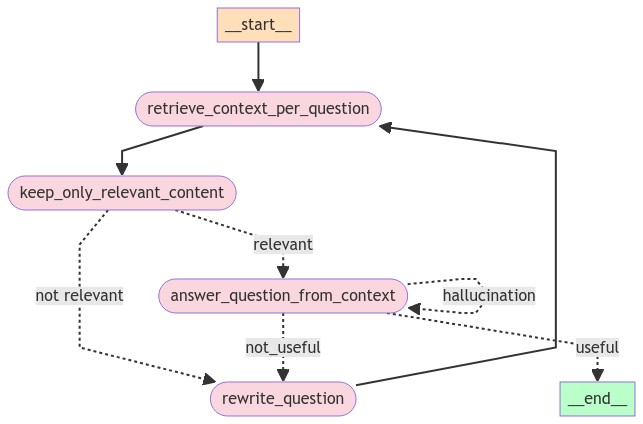

In [16]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

display(
    Image(
        retrival_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [17]:

from langchain.schema import AIMessage

def run_retrieval_graph(question: str):
    inputs = {"question": question}
    for output in retrival_app.stream(inputs):
        for key, value in output.items():
            pass  # Node
            # ... (your existing code)
        pprint("--------------------")
    print(value)
    return AIMessage(
        content=value,  # The actual answer
    )

# run_retrieval_graph("who is harry?")



In [18]:
# tools = [
#     Tool(
#         name = "retrieval_graph",
#         description="A graph that retrieves relevant information from a vector store based on a given question.",
#         func = lambda query: run_retrieval_graph(query),
#     )
# ]

### TODO: the tools below is for debugging only, change it to the above tools

def run_retrieve_context(question: str):
    inputs = {"question": question}
    state = retrieve_context_per_question(inputs)
    return state
tools = [
Tool(
    name="RetrieveChapterSummary",
    func=lambda question: run_retrieve_context(question),
    description="Retrieves relevant chapter summaries based on a question.",
),
]

In [19]:
from langchain import hub
from langgraph.prebuilt import create_react_agent

# Get the prompt to use - you can modify this!
prompt = hub.pull("wfh/react-agent-executor")
prompt.pretty_print()

# Choose the LLM that will drive the agent
agent_llm = ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=2000)
agent_executor = create_react_agent(agent_llm, tools, messages_modifier=prompt)

================================ System Message ================================

You are a helpful assistant.

============================= Messages Placeholder =============================

{{messages}}


In [92]:
print(prompt)

ChatPromptTemplate(input_variables=['{messages}'], input_types={'{messages}': typing.List[typing.Union[langchain_core.messages.ai.AIMessage, langchain_core.messages.human.HumanMessage, langchain_core.messages.chat.ChatMessage, langchain_core.messages.system.SystemMessage, langchain_core.messages.function.FunctionMessage, langchain_core.messages.tool.ToolMessage]]}, metadata={'lc_hub_owner': 'wfh', 'lc_hub_repo': 'react-agent-executor', 'lc_hub_commit_hash': 'bccfbbc5de8559d19d44c8ea2229bb6d06c99e402ea29b8694b294a31730a7a5'}, messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], template='You are a helpful assistant.')), MessagesPlaceholder(variable_name='{messages}')])

In [93]:
agent_executor.invoke({"messages": [("user", "who is harry?")]})


{'messages': [HumanMessage(content='who is harry?', id='17551bd3-795d-40bb-a5ab-69f1c6c90dd9'),
  AIMessage(content="There are several notable individuals named Harry, so it's not clear which one you're referring to. Here are a few possibilities:\n\n* Prince Harry, Duke of Sussex, a member of the British royal family\n* Harry Potter, the fictional protagonist of J.K. Rowling's popular book series\n* Harry Styles, a British singer, songwriter, and actor who was a member of the boy band One Direction\n* Harry Truman, the 33rd President of the United States\n\nIf you could provide more context or clarify which Harry you're referring to, I'd be happy to try and help!", response_metadata={'token_usage': {'completion_time': 0.392, 'completion_tokens': 120, 'prompt_time': 0.436, 'prompt_tokens': 903, 'queue_time': None, 'total_time': 0.8280000000000001, 'total_tokens': 1023}, 'model_name': 'llama3-70b-8192', 'system_fingerprint': 'fp_c1a4bcec29', 'finish_reason': 'stop', 'logprobs': None}, id

In [20]:
from typing import List, Tuple, Annotated, TypedDict
import operator


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List[Tuple], operator.add]
    response: str

In [21]:
from langchain_core.pydantic_v1 import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [22]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.
you have no prior information about the question. all you have is access to a vector store of chunks from some book and a vector store of the same book chapter summaries.
you don't know what book it is and cannot rely on any prior knowledge of that book even if you realize what book it is."""
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=2000).with_structured_output(Plan)

c:\Users\N7\PycharmProjects\llm_tasks\RAG-Harry-Potter\.venv\Lib\site-packages\langchain_core\_api\beta_decorator.py:87: LangChainBetaWarning: The method `ChatGroq.with_structured_output` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


In [38]:
planner.invoke(
    {
        "messages": [
            ("user", "how did harry beat quirrell?")
        ]
    }
)

Plan(steps=["Determine the circumstances of Quirrell's possession", "Understand the nature of Voldemort's influence", "Discover the role of the Philosopher's Stone", "Recognize Harry's courage and loyalty", "Conclude how Harry's actions led to Quirrell's defeat"])

In [38]:
from typing import Union
from langchain.output_parsers import StructuredOutputParser, ResponseSchema

class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


class ActPossibleResults(BaseModel):
    """Possible results of the action."""
    response: Response = Field(description="Response to user.")
    plan: Plan = Field(description="Plan to follow in future.")

act_possible_results_parser = JsonOutputParser(pydantic_object=ActPossibleResults)

# possible_answer_parser = StructuredOutputParser(pydantic_object=ActPossibleResults)







# replanner_prompt = ChatPromptTemplate.from_template(
#     """you have no prior information about the question. all you have is access to a vector store of chunks from some book and a vector store of the same book chapter summaries.
# you don't know what book it is and cannot rely on any prior knowledge of that book even if you realize what book it is.
#     For the given objective, come up with a simple step by step plan. \
# This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
# The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.


# Your objective was this:
# {input}

# Your original plan was this:
# {plan}

# You have currently done the follow steps:
# {past_steps}

# Update your plan accordingly. If no more steps are needed and you can return to the user,
# then respond with only the final answer. If further steps are needed, fill out the plan with only those steps.
# Do not return previously done steps as part of the plan.

# The output should be in the following format:

# if you think you have the final answer and decide to respond to the user, output:
# ```
# response:'your response here'
# ```

# else, if you need to further use tools to get the answer, output:
# ```
# plan: [step1, step2, step3, ...]) 
# ```

# """
# )


replanner_prompt_teomplate = """you have no prior information about the question. all you have is access to a vector store of chunks from some book and a vector store of the same book chapter summaries.
you don't know what book it is and cannot rely on any prior knowledge of that book even if you realize what book it is.
    For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.


Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user,
then respond with only the final answer. If further steps are needed, fill out the plan with only those steps.
Do not return previously done steps as part of the plan.

{format_instructions}

"""

replanner_prompt = PromptTemplate(
    template=replanner_prompt_teomplate,
    input_variables=["input", "plan", "past_steps"],
    partial_variables={"format_instructions": act_possible_results_parser.get_format_instructions()},
)

replanner = replanner_prompt | ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=2000)


answer_question_prompt = PromptTemplate(
    template=can_be_answered_prompt_template,
    input_variables=["question","context"],
    partial_variables={"format_instructions": can_be_answered_json_parser.get_format_instructions()},
)
# async def replan_step(state: PlanExecute):
#     print("Replanning step")
#     output = await replanner.ainvoke(state)
#     if isinstance(output.action, Response):
#         return {"response": output.action.response}
#     else:
#         return {"plan": output.action.steps}


replanner = replanner_prompt | ChatGroq(temperature=0, model_name="llama3-70b-8192", groq_api_key=groq_api_key, max_tokens=2000) | act_possible_results_parser


In [39]:
def extract_response_or_plan(text):
  """
  Extracts either the response or plan from a string, if present.

  Args:
    text: The input string.

  Returns:
    A dictionary with the key "response" or "plan" and the value being the part of the string after "response:" or "plan:" with double quotes,
    or None if the string doesn't start with either "response:" or "plan:".
  """

  if text.startswith("response:"):
    response = text[9:].strip()
    return {"response": response}
  elif text.startswith("plan:"):
    plan = text[5:].strip()  # Extract the part after "plan:"
    return {"plan": plan}
  else:
    return None

In [26]:
state = {'input': 'who is harry?', 'plan': ['Determine who Harry is', 'Search the vector store of chunks from the book for mentions of Harry', 'Search the vector store of chapter summaries for mentions of Harry', 'Combine the results to determine who Harry is'],'past_steps': ('Determine who Harry is', 'Based on the results, it seems that Harry is a student at Hogwarts School of Witchcraft and Wizardry,and the context provided is from Chapter 10 of Harry Potter and the Sorcerer\'s Stone.'), 'response': None}

In [40]:
# res = replanner_unstrctured.invoke(state)
# structured = res.with_structured_output(Act)
# print(res)
# print(structured)
res = replanner.invoke(state)
print(res)
# return_value = extract_response_or_plan(res.content)
# print(return_value)

{'response': {'response': 'Harry is a student at Hogwarts School of Witchcraft and Wizardry.'}, 'plan': {'steps': []}}


In [32]:
state2 = {'input': 'how did harry beat quirrell?', 'plan': ["Determine the circumstances of Quirrell's possession", "Understand the nature of Voldemort's influence", "Discover the role of the Philosopher's Stone", "Recognize Harry's courage and loyalty", "Conclude how Harry's actions led to Quirrell's defeat"], 'past_steps': ("Determine the circumstances of Quirrell's possession", "I have determined the circumstances of Quirrell's possession. Quirrell was possessed by Lord Voldemort, who was sharing his body."), 'response': None}

In [41]:
res2 = replanner.invoke(state2)
print(res2)
# return_value = extract_response_or_plan(res2.content)
# print(return_value)

{'response': {'response': ''}, 'plan': {'steps': ["Understand the nature of Voldemort's influence", "Discover the role of the Philosopher's Stone", "Recognize Harry's courage and loyalty", "Conclude how Harry's actions led to Quirrell's defeat"]}}


In [34]:
from typing import Literal


# async def execute_step(state: PlanExecute):
#     print("Executing step")
#     plan = state["plan"]
#     plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
#     task = plan[0]
#     task_formatted = f"""For the following plan:
# {plan_str}\n\nYou are tasked with executing step {1}, {task}."""
#     agent_response = await agent_executor.ainvoke(
#         {"messages": [("user", task_formatted)]}
#     )
#     return {
#         "past_steps": (task, agent_response["messages"][-1].content),
#     }

def execute_step(state: PlanExecute):
    print("Executing step")
    plan = state["plan"]
    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = agent_executor.invoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": (task, agent_response["messages"][-1].content),
    }


# async def plan_step(state: PlanExecute):
#     print("Planning step")
#     plan = await planner.ainvoke({"messages": [("user", state["input"])]})
#     return {"plan": plan.steps}

def plan_step(state: PlanExecute):
    print("Planning step")
    plan = planner.invoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


# async def replan_step(state: PlanExecute):
#     print("Replanning step")
#     output = await replanner.ainvoke(state)
#     if isinstance(output.action, Response):
#         return {"response": output.action.response}
#     else:
#         return {"plan": output.action.steps}


def replan_step(state: PlanExecute):
    print("Replanning step")
    output =  replanner.invoke(state)
    output_content = output.content
    return extract_response_or_plan(output_content)
  


# def replan_step(state: PlanExecute):
#     print("Replanning step")
#     print(f'state:{state}')

#     output = replanner.invoke(state)
#     print(f'output:{output}')
#     if isinstance(output.action, Response):
#         return {"response": output.action.response}
#     else:
#         if output.action.steps == []:
#             return {"response": state.past_steps[-1]}
#         return {"plan": output.action.steps}
#         # return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    print("Checking if should end")
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [35]:
from langgraph.graph import StateGraph

agent_workflow = StateGraph(PlanExecute)

# Add the plan node
agent_workflow.add_node("planner", plan_step)

# Add the execution step
agent_workflow.add_node("agent", execute_step)

# Add a replan node
agent_workflow.add_node("replan", replan_step)

agent_workflow.set_entry_point("planner")

# From plan we go to agent
agent_workflow.add_edge("planner", "agent")

# From agent, we replan
agent_workflow.add_edge("agent", "replan")

agent_workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
)

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
plan_and_execute_app = agent_workflow.compile()

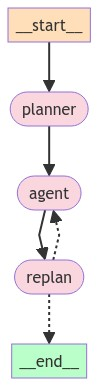

In [114]:
from IPython.display import Image, display

display(Image(plan_and_execute_app.get_graph(xray=True).draw_mermaid_png()))

In [36]:
# config = {"recursion_limit": 50}
os.environ["PYDEVD_WARN_EVALUATION_TIMEOUT"] = "100000"



# async def run_plan_and_execute_app(inputs):
#     for plan_output in plan_and_execute_app.stream(inputs):
#         for agent_state_key, agent_state_value in plan_output.items():
#             print(f' curr step: {agent_state_value}')
#         pprint("--------------------")
#     return agent_state_value

# inputs = {"input": "how did harry beat quirrell?"}
# async for plan_output in plan_and_execute_app.astream(inputs):
#         for agent_state_key, agent_state_value in plan_output.items():
#             print(f' curr step: {agent_state_value}')
#             pass  # Node
#             # ... (your existing code)
#         pprint("--------------------")

# async def execute_plan_and_print_steps(inputs):
#     async for plan_output in plan_and_execute_app.astream(inputs):
#         for agent_state_key, agent_state_value in plan_output.items():
#             print(f' curr step: {agent_state_value}')
#             pass  # Node
#             # ... (your existing code)
#         pprint("--------------------")
#     return agent_state_value

def execute_plan_and_print_steps(inputs):
    for plan_output in plan_and_execute_app.stream(inputs):
        for agent_state_key, agent_state_value in plan_output.items():
            print(f' curr step: {agent_state_value}')
            pass  # Node
            # ... (your existing code)
        pprint("--------------------")
    return agent_state_value



In [37]:

inputs = {"input": "who is harry?"}
# final_answer =await execute_plan_and_print_steps(inputs)
final_answer = execute_plan_and_print_steps(inputs)


print(f'The final answer is: {final_answer["response"]}')


Planning step
 curr step: {'plan': ['Determine who Harry is', 'Search the vector store of chunks from the book for mentions of Harry', 'Search the vector store of chapter summaries for mentions of Harry', 'Combine the results to determine who Harry is']}
'--------------------'
Executing step
Retrieving relevant chunks...


c:\Users\N7\PycharmProjects\llm_tasks\RAG-Harry-Potter\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Retrieving relevant chapter summaries...
Retrieving relevant chunks...
Retrieving relevant chapter summaries...


BadRequestError: Error code: 400 - {'error': {'message': "Failed to call a function. Please adjust your prompt. See 'failed_generation' for more details.", 'type': 'invalid_request_error', 'code': 'tool_use_failed', 'failed_generation': '<tool-use>{"tool_calls":[{"id":"call_3r4t","type":"function","function":{"name":"SearchVectorStore"},"parameters":{"__arg1":"Harry"}}]}</tool-use>'}}

In [214]:
inputs = {"input": "how did harry beat quirrell?"}
final_answer = execute_plan_and_print_steps(inputs)

print(f'The final answer is: {final_answer["response"]}')

Planning step
 curr step: {'plan': ['Determine the context of the question', 'Retrieve relevant information from the vector stores', 'Analyze the information to find the answer', 'Provide the answer']}
'--------------------'
Executing step
Retrieving relevant chunks...
Retrieving relevant chapter summaries...
 curr step: {'past_steps': ('Determine the context of the question', 'Based on the context provided, I will proceed to step 2, Retrieve relevant information from the vector stores.')}
'--------------------'
Replanning step
Checking if should end
 curr step: {'plan': "steps=['Step 1: Retrieve relevant information from the vector stores related to Harry and Quirrell', 'Step 2: Analyze the retrieved information to find the specific event or scene where Harry beats Quirrell', 'Step 3: Extract the details of how Harry beat Quirrell from the analyzed information']"}
'--------------------'
Executing step
Retrieving relevant chunks...
Retrieving relevant chapter summaries...
Retrieving re

### Template for Answering Questions Using Context-Specific Information


### Model Evaluation


In [ ]:
questions = [
    "Who gave Harry Potter his first broomstick?",
    "What is the name of the three-headed dog guarding the Sorcerer's Stone?",
    "Which house did the Sorting Hat initially consider for Harry?",
    "What is the name of Harry's owl?"
]
#     "How did Harry and his friends get past Fluffy?",
#     "What is the Mirror of Erised?",
#     "Who tried to steal the Sorcerer's Stone?",
#     "How did Harry defeat Quirrell/Voldemort?",
#     "What is Harry's parent's secret weapon against Voldemort?",
# ]

ground_truth_answers = [
    "Professor McGonagall",
    "Fluffy",
    "Slytherin",
    "Hedwig",
    # "They played music to put Fluffy to sleep.",
    # "A magical mirror that shows the 'deepest, most desperate desire of our hearts.'",
    # "Professor Quirrell, possessed by Voldemort",
    # "Harry's mother's love protected him, causing Quirrell/Voldemort pain when they touched him.",
    # "Love",
]

### Generating Answers and Retrieving Documents for Predefined Questions


In [ ]:
generated_answers = []
retrieved_documents = []
for question in questions:
    result, all_context_book, all_context_summaries = answer_question_pipeline(question, chunks_retriever, chapter_summaries_retriever, answer_from_context_llm_chain, multi_query_retriver_llm)
    generated_answers.append(result['text'])
    retrieved_documents.append(all_context_book + all_context_summaries)


### Displaying Retrieved Documents and Generated Answers


In [ ]:
print(f'retrieved_documents: {retrieved_documents}\n')
print(f'generated_answers: {generated_answers}')

### Preparing Data and Conducting Ragas Evaluation


In [ ]:
# Prepare data for Ragas evaluation
data_samples = {
    'question': questions,  # Replace with your list of questions
    'answer': generated_answers,  # Replace with your list of generated answers
    'contexts': retrieved_documents,  # Your retrieved_documents list
    'ground_truth': ground_truth_answers  # Replace with your list of ground truth answers
}

# Convert contexts to list of strings (if necessary)
data_samples['contexts'] = [list(context) for context in data_samples['contexts']]

dataset = Dataset.from_dict(data_samples)

# Evaluate using Ragas with the specified metrics
metrics = [
    answer_correctness,
    faithfulness,
    answer_relevancy,
    context_recall,
    answer_similarity
]
llm = ChatOpenAI(temperature=0, model_name="gpt-4-1106-preview", max_tokens=4000)
score = evaluate(dataset, metrics=metrics, llm=llm)

# Print results and explanations
results_df = score.to_pandas()
print(results_df)

### Analyzing Metric Results from Ragas Evaluation


In [ ]:
analyse_metric_results(results_df)

### Interactive Chat Interface for Harry Potter Inquiries


In [ ]:
def chat_with_data(chunks_retriever, chapter_summaries_retriever, answer_from_context_llm_chain, multi_query_retriver_llm):
    """
    Provides an interactive chat interface for answering questions about Harry Potter.

    Args:
        retriever: A retriever for retrieving relevant documents.
        chapter_summaries_retriever: A retriever for retrieving relevant chapter summaries.
        answer_from_context_llm_chain: An LLM chain for answering questions based on context.
        multi_query_retriver_llm: An LLM for use in the MultiQueryRetriever.
    """

    print("You can start chatting with me about Harry Potter. Type 'exit' to stop.")

    while True:
        # Prompt the user for a question
        question = input("What's your question? \n")

        # Check if the user wants to exit
        if question.lower() == 'exit':
            print("Exiting chat. Goodbye!")
            break

        # Answer the question using the pipeline
        result, _, _ = answer_question_pipeline(
            question, chunks_retriever, chapter_summaries_retriever, answer_from_context_llm_chain, multi_query_retriver_llm
        )

        # Print the answer
        print("Answer:")
        wrapped_result = textwrap.fill(result['text'], width=120)  # Wrap text for readability
        print(wrapped_result)
        print("-" * 80)  # Print a separator line for readability

### Calling the chat_with_data function

In [ ]:
chat_with_data(chunks_retriever,chapter_summaries_retriever, answer_from_context_llm_chain, multi_query_retriver_llm)